In [29]:
%matplotlib inline

In [31]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

matplotlib.rc("figure", figsize=(8, 6))

colors = cm.tab10(np.linspace(0, 1, 10))

In [33]:
df = pd.read_csv("data/aircraft.csv", index_col=0)

X = df.max_weight.values
Y = df.max_thrust.values
Type = df.index.values

In [34]:
def plotdata(ax, text=True, label=True):
    xlabel = "Maximum weight (t)"
    ylabel = "Maximum thrust (kN)"

    ax.scatter(X, Y, color="k", s=40, zorder=10, facecolor='w', lw=2)

    if label:
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

    if text:
        for x, y, t in zip(X, Y, Type):
            # move the text label around
            if t in ["B737", "B788", "B77W"]:
                y += max(Y) / 20
                x -= max(X) / 20
            else:
                x += max(X) / 50
            ax.text(x, y, t, ha="left", va="center", fontsize=10)

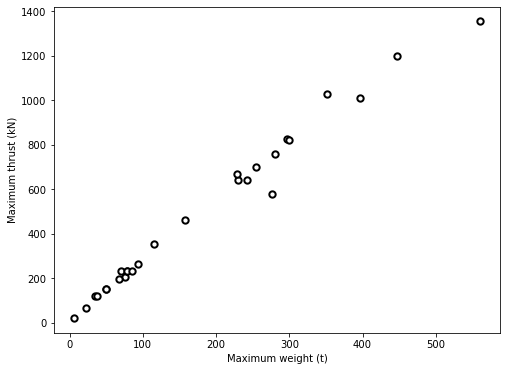

In [35]:
b1, b0 = np.polyfit(X, Y, deg=1)

X_ = np.linspace(0, 600, 10)

fig, ax = plt.subplots(1)
plotdata(ax, text=False)
# ax.plot(X_, b0 + b1 * X_)
plt.show()

Is this the only model that represents the data? How about the following line?

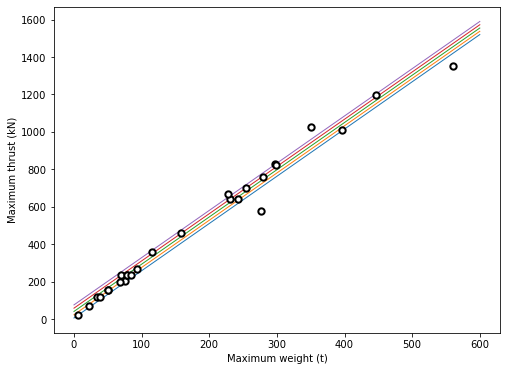

In [36]:
fig, ax = plt.subplots(1)
plotdata(ax, text=False)
for eps in np.linspace(-30, 40, 5):
    ax.plot(X_, b0+eps + b1 * X_, lw=1)
plt.show()

Even though the previous line fits the best in terms of RSME. We are also argue the other line in the figure below should also be allow to represent the data.

This is when Bayesian regression can be useful. In stead of produce a single regression model with fixed coefficient $\beta$. We want to find out what is the probability distributions of the coefficients.

# Bayesian linear regression

You have already seen the linear regression model:

$$
\mathbf{y} = \mathbf{X} \beta + \epsilon
$$

The Bayesian linear model can be expressed as follows:

$$
\mathbf{y} \sim \mathcal{N}(\mathbf{X} \beta, \sigma^2)
$$

It considers the output $\mathbf{y}$ as a random variable (or vector), where each data point is distributed according to a Normal distribution. This distribution has the mean product of coefficents and input and has a varaince of $\sigma^2$.

In [37]:
import pymc3 as pm

In [38]:
with pm.Model() as model:
    sigma = pm.HalfNormal('sigma', 0, sd=30)
    beta_0 = pm.Normal('beta_0', 0, sd=20)
    beta_1 = pm.Normal('beta_1', 0, sd=20)

    y = pm.Normal('y', mu=beta_0+beta_1*X, sd=sigma, observed=Y)

    trace = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_1, beta_0, sigma]
█Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


<Figure size 504x504 with 0 Axes>

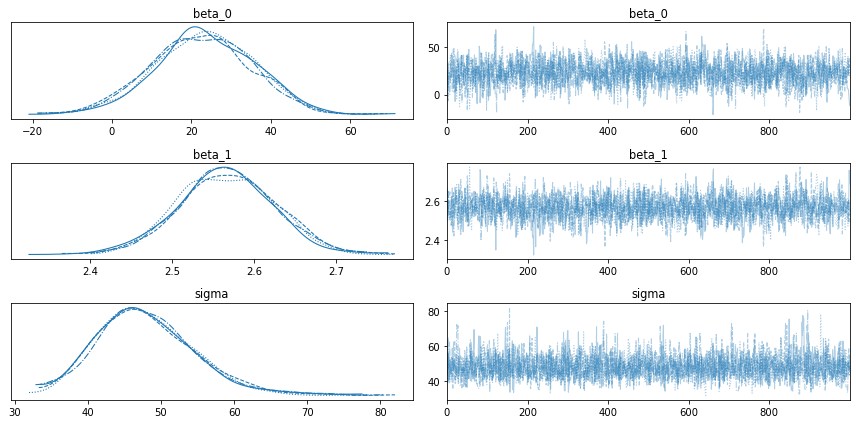

In [39]:
plt.figure(figsize=(7, 7))
pm.traceplot(trace)
plt.tight_layout()
plt.show()

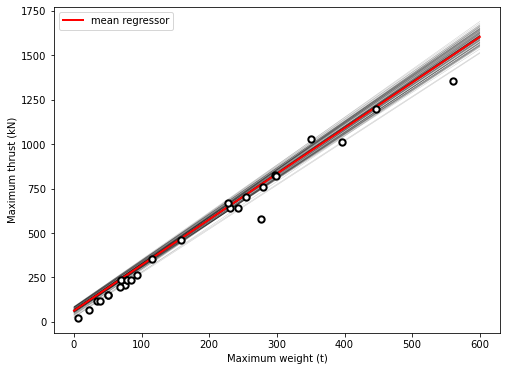

In [40]:
fig, ax = plt.subplots(1)
plotdata(ax, text=False)

for i in range(100):
    b0 = np.random.choice(trace['beta_0'])
    b1 = np.random.choice(trace['beta_1'])
    ax.plot(X_, b0+eps + b1 * X_, lw=0.5, color='k', alpha=0.2)

b0 = trace['beta_0'].mean()
b1 = trace['beta_1'].mean()
ax.plot(X_, b0+eps + b1 * X_, lw=2, color='r', label="mean regressor")

plt.legend()

plt.show()